In [61]:
import os
import numpy as np
import matplotlib.pyplot as plt

import cv2

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [62]:
np.__version__

'1.19.2'

In [63]:
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

In [64]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    physical_devices = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


In [65]:
# Path to the data directory
data_dir = Path("./data/CAPTCHA_images/img")

# Get list of all the images
images = sorted(list(map(str, list(data_dir.glob("*.jpg")))))[:10000]
labels = [img.split(os.path.sep)[-1].split(".jpg")[0] for img in images]
characters = set(char for label in labels for char in label)

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

# Batch size for training and validation
batch_size = 30

# Desired image dimensions
img_width = 160
img_height = 60

# Factor by which the image is going to be downsampled
# by the convolutional blocks. We will be using two
# convolution blocks and each block will have
# a pooling layer which downsample the features by a factor of 2.
# Hence total downsampling factor would be 4.
downsample_factor = 2

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels])

Number of images found:  611
Number of labels found:  611
Number of unique characters:  33
Characters present:  {'a', '5', 'h', '6', 'n', 'i', 'q', 's', '3', 't', 'g', '7', 'j', 'd', 'p', 'v', 'u', 'f', 'o', 'w', 'e', '2', 'z', 'c', 'y', 'b', 'k', 'r', 'm', '4', '8', '9', 'x'}


In [66]:
# Mapping characters to integers
char_to_num = layers.experimental.preprocessing.StringLookup(
    vocabulary=list(characters), num_oov_indices=0, mask_token=None
)

# Mapping integers back to original characters
num_to_char = layers.experimental.preprocessing.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)


def split_data(images, labels, train_size=0.9, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid


# Splitting data into training and validation sets
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))


def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}

In [67]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

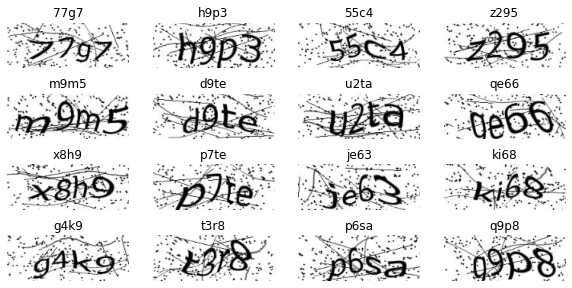

In [68]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [69]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred


def build_model():
    # Inputs to the model
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # First conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(len(characters) + 1, activation="softmax", name="dense2")(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model


# Get the model
model = build_model()
model.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "ocr_model_v1"
______________________________________________________________________________

In [70]:
epochs = 1000
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping]
)

Epoch 1/1000
19/19 [==============================] - 6s 87ms/step - loss: 50.3690 - val_loss: 15.4344
Epoch 2/1000
19/19 [==============================] - 1s 33ms/step - loss: 14.9951 - val_loss: 14.7336
Epoch 3/1000
19/19 [==============================] - 1s 32ms/step - loss: 14.7233 - val_loss: 14.5469
Epoch 4/1000
19/19 [==============================] - 1s 33ms/step - loss: 14.6262 - val_loss: 14.4707
Epoch 5/1000
19/19 [==============================] - 1s 33ms/step - loss: 14.5703 - val_loss: 14.3968
Epoch 6/1000
19/19 [==============================] - 1s 32ms/step - loss: 14.5012 - val_loss: 14.3298
Epoch 7/1000
19/19 [==============================] - 1s 33ms/step - loss: 14.4648 - val_loss: 14.2797
Epoch 8/1000
19/19 [==============================] - 1s 33ms/step - loss: 14.4191 - val_loss: 14.2281
Epoch 9/1000
19/19 [==============================] - 1s 33ms/step - loss: 14.3795 - val_loss: 14.1951
Epoch 10/1000
19/19 [==============================] - 1s 33ms/step - los

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 160, 60, 1)]      0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 160, 60, 32)       320       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 80, 30, 32)        0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 80, 30, 64)        18496     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 40, 15, 64)        0         
_________________________________________________________________
reshape (Reshape)            (None, 40, 960)           0         
_________________________________________________________________
dense1 (Dense)               (None, 40, 64)            6150

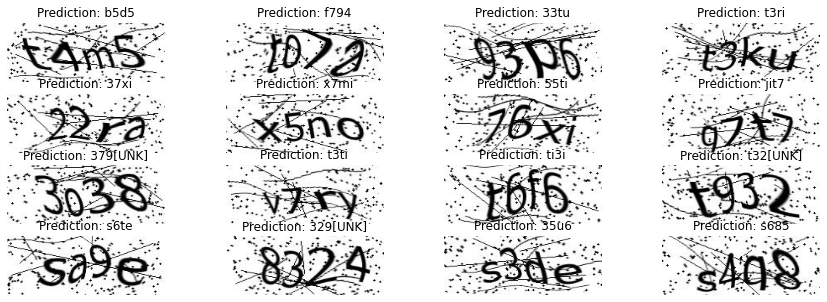

In [71]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
prediction_model.summary()

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some validation samples
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts[:16])):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()

(['b5d5'], <matplotlib.image.AxesImage at 0x7f10a003b070>)

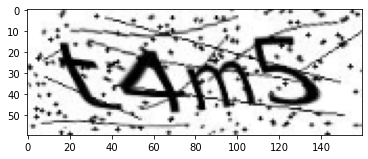

In [72]:
preds = prediction_model.predict(np.array([batch_images[0]]))
pred_texts = decode_batch_predictions(preds)
ax = plt.gca() 
pred_texts, ax.imshow((batch_images[0, :, :, 0] * 255).numpy().astype(np.uint8).T, cmap="gray")


In [73]:
from datetime import datetime

name_model = f"./models/my_model-{datetime.utcnow().strftime('%y-%m-%d_%H%M%S')}"

model.save(name_model)

INFO:tensorflow:Assets written to: ./models/my_model-21-05-22_223429/assets
INFO:tensorflow:Assets written to: ./models/my_model-21-05-22_223429/assets


In [74]:
# It can be used to reconstruct the model identically.
reconstructed_model = keras.models.load_model(name_model)

In [75]:
np.array([batch_images[0]]).shape

(1, 160, 60, 1)

In [76]:
reconstructed_model_pred = keras.models.Model(
    reconstructed_model.get_layer(name="image").input, reconstructed_model.get_layer(name="dense2").output
)

(['b5d5'], <matplotlib.image.AxesImage at 0x7f0ffd955790>)

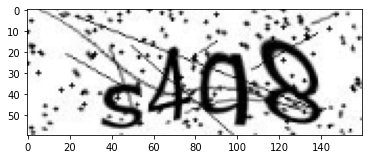

In [77]:
preds = reconstructed_model_pred.predict(np.array([batch_images[0]]))
pred_texts = decode_batch_predictions(preds)
ax = plt.gca() 
pred_texts, ax.imshow((batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8).T, cmap="gray")

In [78]:
# Store arrays in memory as it's not a muvh big dataset
def generate_arrays(df, resize=True, img_height=50, img_width=200):
    """Generates image array and labels array from a dataframe.
    
    Args:
        df: dataframe from which we want to read the data
        resize (bool)    : whether to resize images or not
        img_weidth (int): width of the resized images
        img_height (int): height of the resized images
        
    Returns:
        images (ndarray): grayscale images
        labels (ndarray): corresponding encoded labels
    """
    
    num_items = len(df)
    images = np.zeros((num_items, img_height, img_width), dtype=np.float32)
    labels = [0]*num_items
    
    for i in range(num_items):
        img = cv2.imread(df["img_path"][i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        if resize: 
            img = cv2.resize(img, (img_width, img_height))
        
        img = (img/255.).astype(np.float32)
        label = df["label"][i]
        
        
        images[i, :, :] = img
        labels[i] = label
    
    return images, np.array(labels)

In [79]:
import pandas as pd
data={
    "img_path":"./data/CAPTCHA_images/img/x5no.jpg",
"label":"x5no"
}
df_test = pd.DataFrame([data])
data_test, labels_test = generate_arrays(df_test, resize=True, img_height=60, img_width=160)

In [80]:
df_test

,img_path,label
0,./data/CAPTCHA_images/img/x5no.jpg,x5no


In [81]:
np.array([data_test.T]).shape

(1, 160, 60, 1)

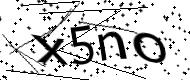

(['x7mi'], None)

In [82]:
from IPython.display import display
from PIL import Image
preds = reconstructed_model_pred.predict(np.array([data_test.T]))
pred_texts = decode_batch_predictions(preds)
pred_texts, display(Image.open(data['img_path']))